In [8]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
import scienceplots
plt.style.use(['science', 'grid', 'ieee'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [9]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/data2/data_0001.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 8', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 13.89% of all events


In [10]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False):
    tracks = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 4 and len(hitsY) > 4:
            # get track parameters
            track = Track3D(hits)
            if track.is_good_2D_fit():
                tracks.append(track)

    return tracks

In [11]:
# getting tracks
tracks = create_tracks(df_hits)
new_new_len = len(tracks)
print('selected {:.2f}% of all events'.format(new_new_len/new_len * 100))
# %reload_ext line_profiler
# %lprun -f create_tracks create_tracks(df_hits.head(10))

100%|██████████| 102631/102631 [17:57<00:00, 95.24it/s] 


selected 54.88% of all events


In [12]:
# cos^4 function
def expected(x, A):
    return A * np.cos(x)**2

def expected2D(angles, A):
    return A * np.cos(angles[0])**2 * np.cos(angles[1])

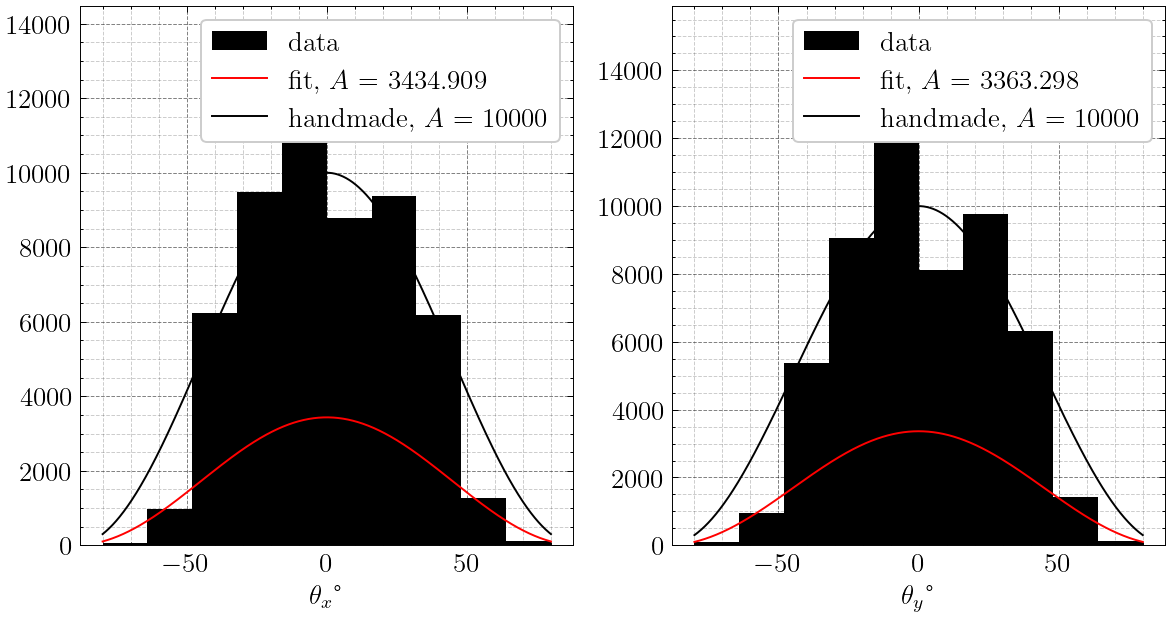

In [13]:
from scipy.optimize import curve_fit

thetas_x = [np.arctan(t.x.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
thetas_y = [np.arctan(t.y.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
bins = 10

xfit = np.linspace(-80, 80, 1000)
xfit_rad = xfit / 180 * np.pi
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
n_x, xs, _ = axs[0].hist(thetas_x, bins = bins, range = [-80, 80], label = 'data')
xs = np.array(xs) + (xs[1] - xs[0])/2
popt_x, pcov_x = curve_fit(expected, xs[:-1], n_x, bounds = (0, np.inf), p0 = 10000)
axs[0].plot(xfit, expected(xfit_rad, popt_x[0]), 'r-', label = 'fit, $A$ = {:.3f}'.format(popt_x[0]))
axs[0].plot(xfit, expected(xfit_rad, 10000), 'k-', label = 'handmade, $A$ = 10000')
axs[0].set(xlabel = r'$\theta_x$°')
axs[0].legend()
axs[0].grid(which = 'major', alpha = 0.5)
axs[0].grid(which = 'minor', alpha = 0.2)

n_y, ys, _ = axs[1].hist(thetas_y, bins=bins, range=[-80, 80], label='data')
ys = np.array(ys) + (ys[1] - ys[0])/2
popt_y, pcov_y = curve_fit(expected, ys[:-1], n_y, bounds = (0, np.inf), p0 = 10000)
axs[1].plot(xfit, expected(xfit_rad, popt_y[0]), 'r-', label='fit, $A$ = {:.3f}'.format(popt_y[0]))
axs[1].plot(xfit, expected(xfit_rad, 10000), 'k-', label='handmade, $A$ = 10000')
axs[1].set(xlabel = r'$\theta_y$°')
axs[1].legend()
axs[1].grid(which = 'major', alpha = 0.5)
axs[1].grid(which = 'minor', alpha = 0.2)

fig.savefig('../figs/angle_distribution_uncalibrated.pdf')

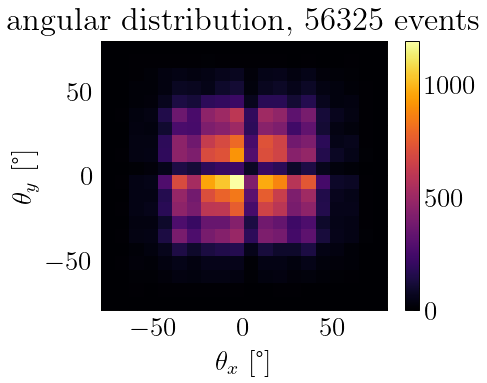

In [14]:
# 2D hist of angular distribution
plt.figure()
plt.title('angular distribution, {} events'.format(len(thetas_x)))
h, xs, ys, img = plt.hist2d(thetas_x, thetas_y, bins = 20, range = [[-80, 80], [-80, 80]], cmap = 'inferno')
plt.xlabel(r"$\theta_x$ [°]")
plt.ylabel(r"$\theta_y$ [°]")
plt.colorbar()